Loaded posterior mean probability matrix with shape: (499, 43)


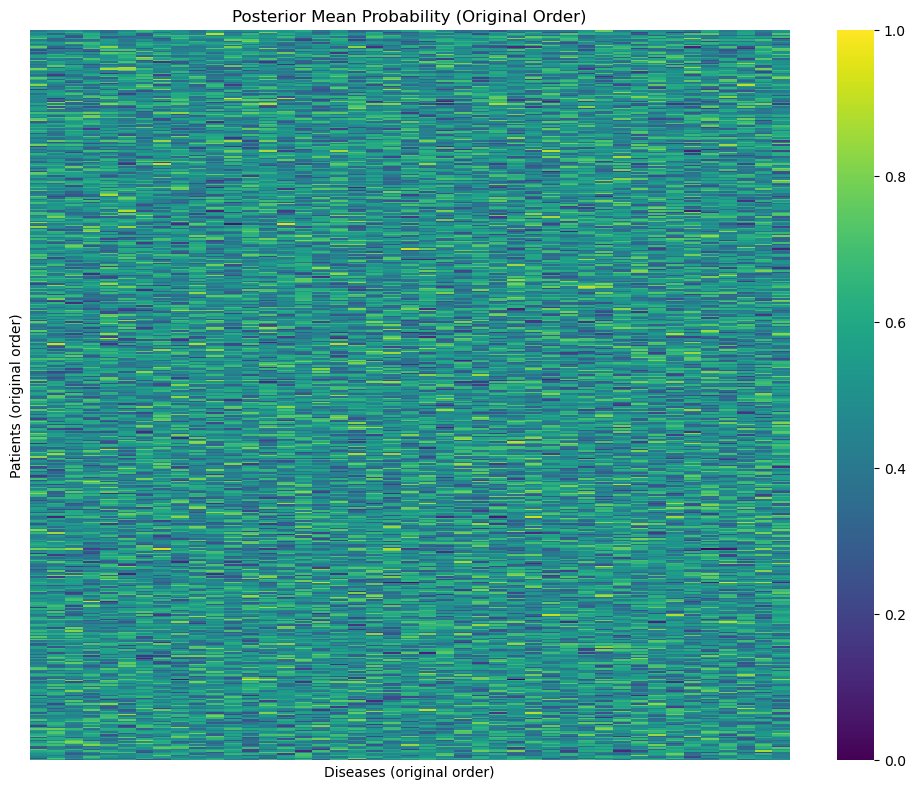

In [4]:
# Heatmap of posterior mean probabilities for a single shard (original order)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def _sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


def load_posterior_mean_probability_matrix(results_dir: str) -> np.ndarray:
    """
    Load posterior samples from a results directory and return the posterior mean
    probability matrix of shape (num_patients, num_conditions).

    Supports:
    - Single-shard outputs: mcmc_samples.npy with key 'Lambda' (logits) or 'f'
    - Combined outputs: combined_post_samples.npy possibly with key 'p' (probabilities)
    """
    if not os.path.isdir(results_dir):
        raise FileNotFoundError(f"Results directory not found: {results_dir}")

    combined_path = os.path.join(results_dir, 'combined_post_samples.npy')
    shard_path = os.path.join(results_dir, 'mcmc_samples.npy')

    if os.path.exists(combined_path):
        payload = np.load(combined_path, allow_pickle=True).item()
        if 'p' in payload:
            p = payload['p']
            if p.ndim == 2:
                return np.asarray(p)
            elif p.ndim == 3:
                # mean over draws
                return np.mean(p, axis=0)
        # Fallback: compute from logits if present
        for logits_key in ('f', 'Lambda'):
            if logits_key in payload:
                logits = np.asarray(payload[logits_key])
                if logits.ndim == 2:
                    return _sigmoid(logits)
                elif logits.ndim == 3:
                    return _sigmoid(logits).mean(axis=0)
        raise KeyError("Neither 'p' nor logits ('f'/'Lambda') found in combined results.")

    if os.path.exists(shard_path):
        samples = np.load(shard_path, allow_pickle=True).item()
        # Prefer 'Lambda' (GMRF logits); fallback to 'f'
        for logits_key in ('Lambda', 'f'):
            if logits_key in samples:
                logits = np.asarray(samples[logits_key])
                if logits.ndim == 2:
                    return _sigmoid(logits)
                elif logits.ndim == 3:
                    return _sigmoid(logits).mean(axis=0)
        raise KeyError("Expected 'Lambda' or 'f' in shard samples to compute probabilities.")

    raise FileNotFoundError(
        f"No results files found in {results_dir}. Expected 'mcmc_samples.npy' or 'combined_post_samples.npy'."
    )


# === Set this to your shard results directory ===
# Example: results_dir = '/Users/bernardo/Documents/Code/PharmacyAlloc/Res/gmrf_20250816_134744'
results_dir = '/Users/bernardo/Downloads/gmrf_20250817_231634_shard_1'  # <-- fill in path to a shard directory or a combined results directory

# Load posterior mean probabilities
P_mean = load_posterior_mean_probability_matrix(results_dir)
print(f"Loaded posterior mean probability matrix with shape: {P_mean.shape}")

# Plot heatmap in original order
plt.figure(figsize=(10, 8))
sns.heatmap(P_mean, cmap='viridis', vmin=0.0, vmax=1.0, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Mean Probability (Original Order)')
plt.xlabel('Diseases (original order)')
plt.ylabel('Patients (original order)')
plt.tight_layout()
plt.show()


Loaded probability draws: (4000, 499, 43); std matrix shape: (499, 43)


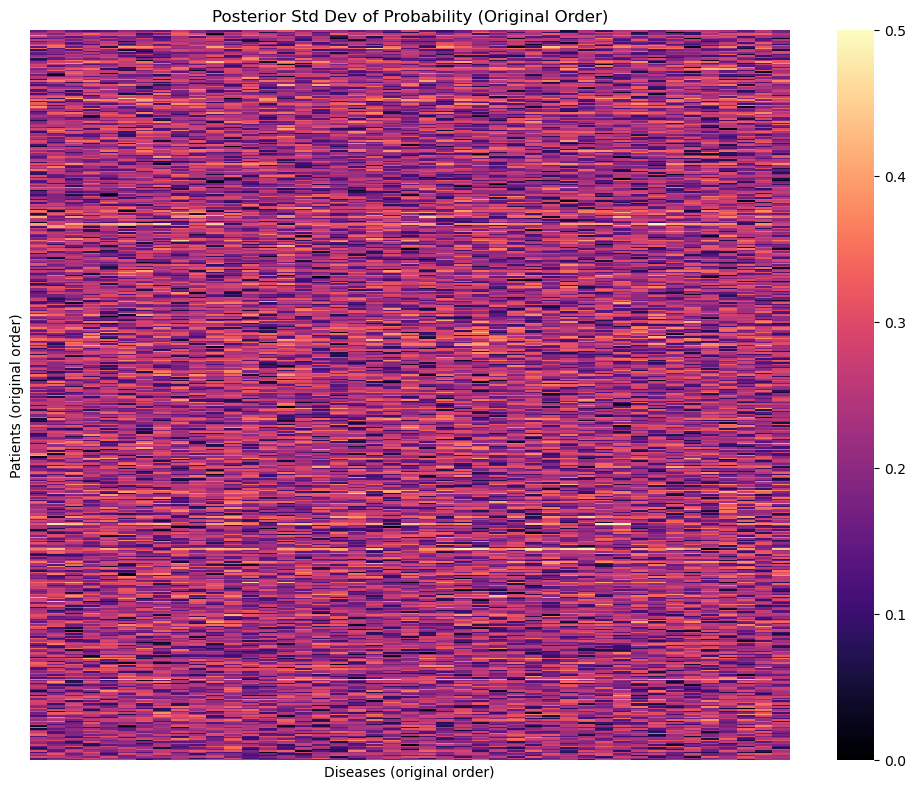

In [5]:
# Heatmap of posterior standard deviation of probabilities (original order)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def load_probability_draws(results_dir: str) -> np.ndarray:
    """
    Return posterior draws of probabilities with shape (num_draws, I, C).
    Supports both combined and single-shard result folders.
    Raises a ValueError if only a single 2D matrix is available.
    """
    combined_path = os.path.join(results_dir, 'combined_post_samples.npy')
    shard_path = os.path.join(results_dir, 'mcmc_samples.npy')

    def _sigmoid(x: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-x))

    if os.path.exists(combined_path):
        payload = np.load(combined_path, allow_pickle=True).item()
        if 'p' in payload:
            p = np.asarray(payload['p'])
            if p.ndim == 3:
                return p
            elif p.ndim == 2:
                # Fall back to logits if per-draw not available
                for logits_key in ('f', 'Lambda'):
                    if logits_key in payload:
                        logits = np.asarray(payload[logits_key])
                        if logits.ndim == 3:
                            return _sigmoid(logits)
                raise ValueError("Combined results provide only a single 2D probability matrix; per-draw std is unavailable.")
        # If 'p' missing, try logits
        for logits_key in ('f', 'Lambda'):
            if logits_key in payload:
                logits = np.asarray(payload[logits_key])
                if logits.ndim == 3:
                    return _sigmoid(logits)
                elif logits.ndim == 2:
                    raise ValueError("Combined results contain only a single 2D latent matrix; per-draw std is unavailable.")
        raise KeyError("No suitable keys found in combined results to derive probability draws ('p', 'f', or 'Lambda').")

    if os.path.exists(shard_path):
        samples = np.load(shard_path, allow_pickle=True).item()
        for logits_key in ('Lambda', 'f'):
            if logits_key in samples:
                logits = np.asarray(samples[logits_key])
                if logits.ndim == 3:
                    return _sigmoid(logits)
                elif logits.ndim == 2:
                    raise ValueError("Shard results contain only a single 2D latent matrix; per-draw std is unavailable.")
        raise KeyError("Expected 'Lambda' or 'f' in shard samples to derive probability draws.")

    raise FileNotFoundError(
        f"No results files found in {results_dir}. Expected 'mcmc_samples.npy' or 'combined_post_samples.npy'."
    )


# Use the same results_dir defined previously
if not results_dir:
    raise RuntimeError("Please set 'results_dir' in the previous cell before running this one.")

# Load per-draw probabilities and compute std across draws
p_draws = load_probability_draws(results_dir)
P_std = np.std(p_draws, axis=0)
print(f"Loaded probability draws: {p_draws.shape}; std matrix shape: {P_std.shape}")

# Plot heatmap of posterior std; std of Bernoulli probs is in [0, 0.5]
plt.figure(figsize=(10, 8))
sns.heatmap(P_std, cmap='magma', vmin=0.0, vmax=0.5, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Std Dev of Probability (Original Order)')
plt.xlabel('Diseases (original order)')
plt.ylabel('Patients (original order)')
plt.tight_layout()
plt.show()


In [6]:
# Patient Embeddings via t-SNE on latent logits (fallback to logit probabilities)
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def _safe_logit(p: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    p = np.clip(p, eps, 1.0 - eps)
    return np.log(p) - np.log(1.0 - p)


def load_latent_mean_matrix(results_dir: str) -> np.ndarray:
    """
    Load the posterior mean latent matrix (I x C).
    Priority:
      1) Use mean of latent logits ('Lambda' or 'f') if present.
      2) Else use 'p' (probabilities) and transform via logit for geometry.
    """
    combined_path = os.path.join(results_dir, 'combined_post_samples.npy')
    shard_path = os.path.join(results_dir, 'mcmc_samples.npy')

    if os.path.exists(combined_path):
        obj = np.load(combined_path, allow_pickle=True).item()
        for key in ('Lambda', 'f'):
            if key in obj:
                arr = np.asarray(obj[key])
                return arr if arr.ndim == 2 else np.mean(arr, axis=0)
        if 'p' in obj:
            arr = np.asarray(obj['p'])
            P = arr if arr.ndim == 2 else np.mean(arr, axis=0)
            return _safe_logit(P)
        raise KeyError("No 'Lambda', 'f', or 'p' in combined results")

    if os.path.exists(shard_path):
        obj = np.load(shard_path, allow_pickle=True).item()
        for key in ('Lambda', 'f'):
            if key in obj:
                arr = np.asarray(obj[key])
                return arr if arr.ndim == 2 else np.mean(arr, axis=0)
        # If only probs present (unlikely for shards), handle
        if 'p' in obj:
            arr = np.asarray(obj['p'])
            P = arr if arr.ndim == 2 else np.mean(arr, axis=0)
            return _safe_logit(P)
        raise KeyError("No 'Lambda', 'f', or 'p' in shard results")

    raise FileNotFoundError("Results not found; expected combined_post_samples.npy or mcmc_samples.npy")


def tsne_embedding(X: np.ndarray, random_state: int = 42) -> np.ndarray:
    n_samples = X.shape[0]
    # Perplexity must be < n_samples; choose conservative default
    perplexity = max(5, min(30, n_samples - 1))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init='pca',
        learning_rate='auto',
        random_state=random_state,
        n_iter=1000,
    )
    return tsne.fit_transform(X)


# Use same results_dir defined earlier
if not results_dir:
    raise RuntimeError("Please set 'results_dir' in the first cell.")

# Latent matrix for patients (I x C)
latent_mean = load_latent_mean_matrix(results_dir)
print(f"Latent mean matrix shape: {latent_mean.shape}")

# Each patient is a row vector in latent space
patient_vectors = latent_mean  # shape (I, C)
patient_embed = tsne_embedding(patient_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(patient_embed[:, 0], patient_embed[:, 1], s=10, alpha=0.8)
plt.title('Patient Embeddings (t-SNE on latent logits)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.axis('equal')
plt.tight_layout()
plt.show()


Latent mean matrix shape: (499, 43)


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

In [ ]:
# Disease Embeddings via t-SNE on latent logits (columns of Λ)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reuse latent_mean from previous cell
if 'latent_mean' not in globals():
    raise RuntimeError("Run the patient embeddings cell first to load latent_mean.")

# Each disease is a column vector; transpose to (C, I)
disease_vectors = latent_mean.T

# t-SNE expects samples as rows
n_samples = disease_vectors.shape[0]
perplexity = max(5, min(30, n_samples - 1))
tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', learning_rate='auto', random_state=42, n_iter=1000)
disease_embed = tsne.fit_transform(disease_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(disease_embed[:, 0], disease_embed[:, 1], s=20, alpha=0.9, color='tab:orange')
plt.title('Disease Embeddings (t-SNE on latent logits)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.axis('equal')
plt.tight_layout()
plt.show()


Loading data and MCMC samples...
Loaded data shape: (100, 39)
Using grid size: n=100, C=39 (for 39 conditions)
Loading MCMC samples from: ./Res/gmrf_20250724_113412
Computing posterior predictives...
Posterior predictive samples shape: (100, 100, 39)
Plotting estimated probability matrix...


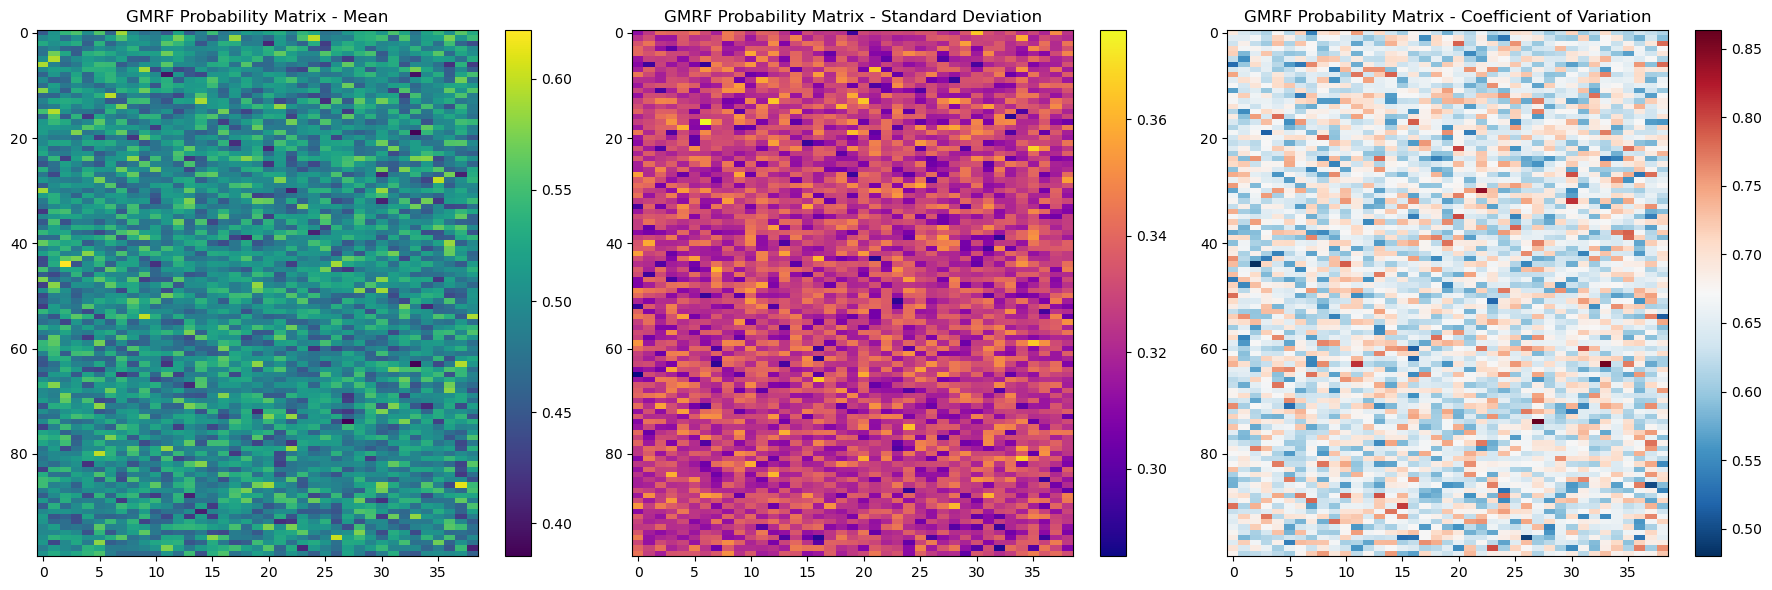


Probability Matrix Summary Statistics:
Mean probability: 0.5005 ± 0.0336
Min probability: 0.3852
Max probability: 0.6217
Mean uncertainty (std): 0.3276 ± 0.0126
Plotting original data for comparison...


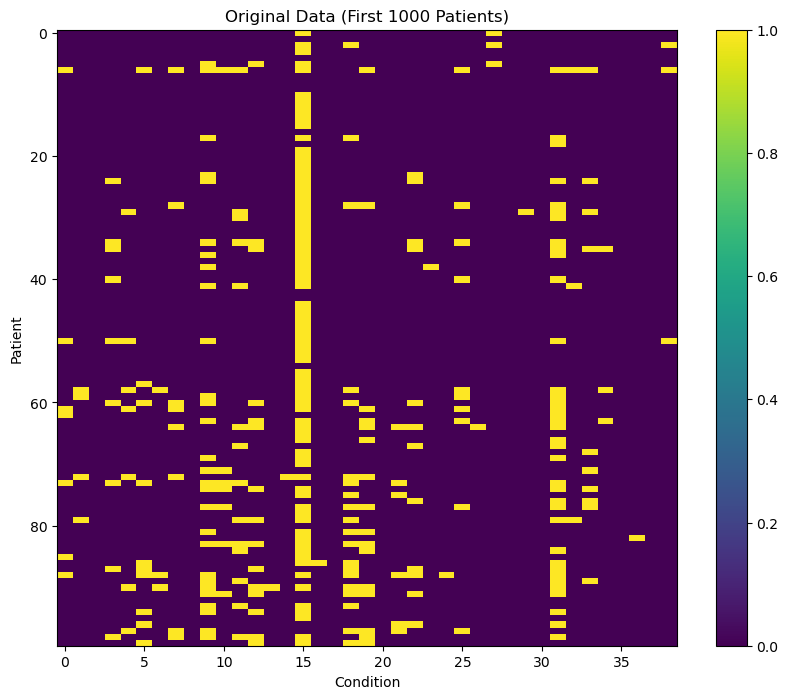

Analysis complete!


Computing confusion matrix...
Debug info:
  probs_mean shape: (100, 39)
  actual_data shape: (100, 39)
  n_patients: 100, n: 100, C: 39
  Padded actual_data with 3861 zeros
  actual_data_grid shape after reshape: (100, 100, 39)
  Final shapes: y_true=(390000,), y_pred_proba=(390000,)
Plotting confusion matrix analysis...


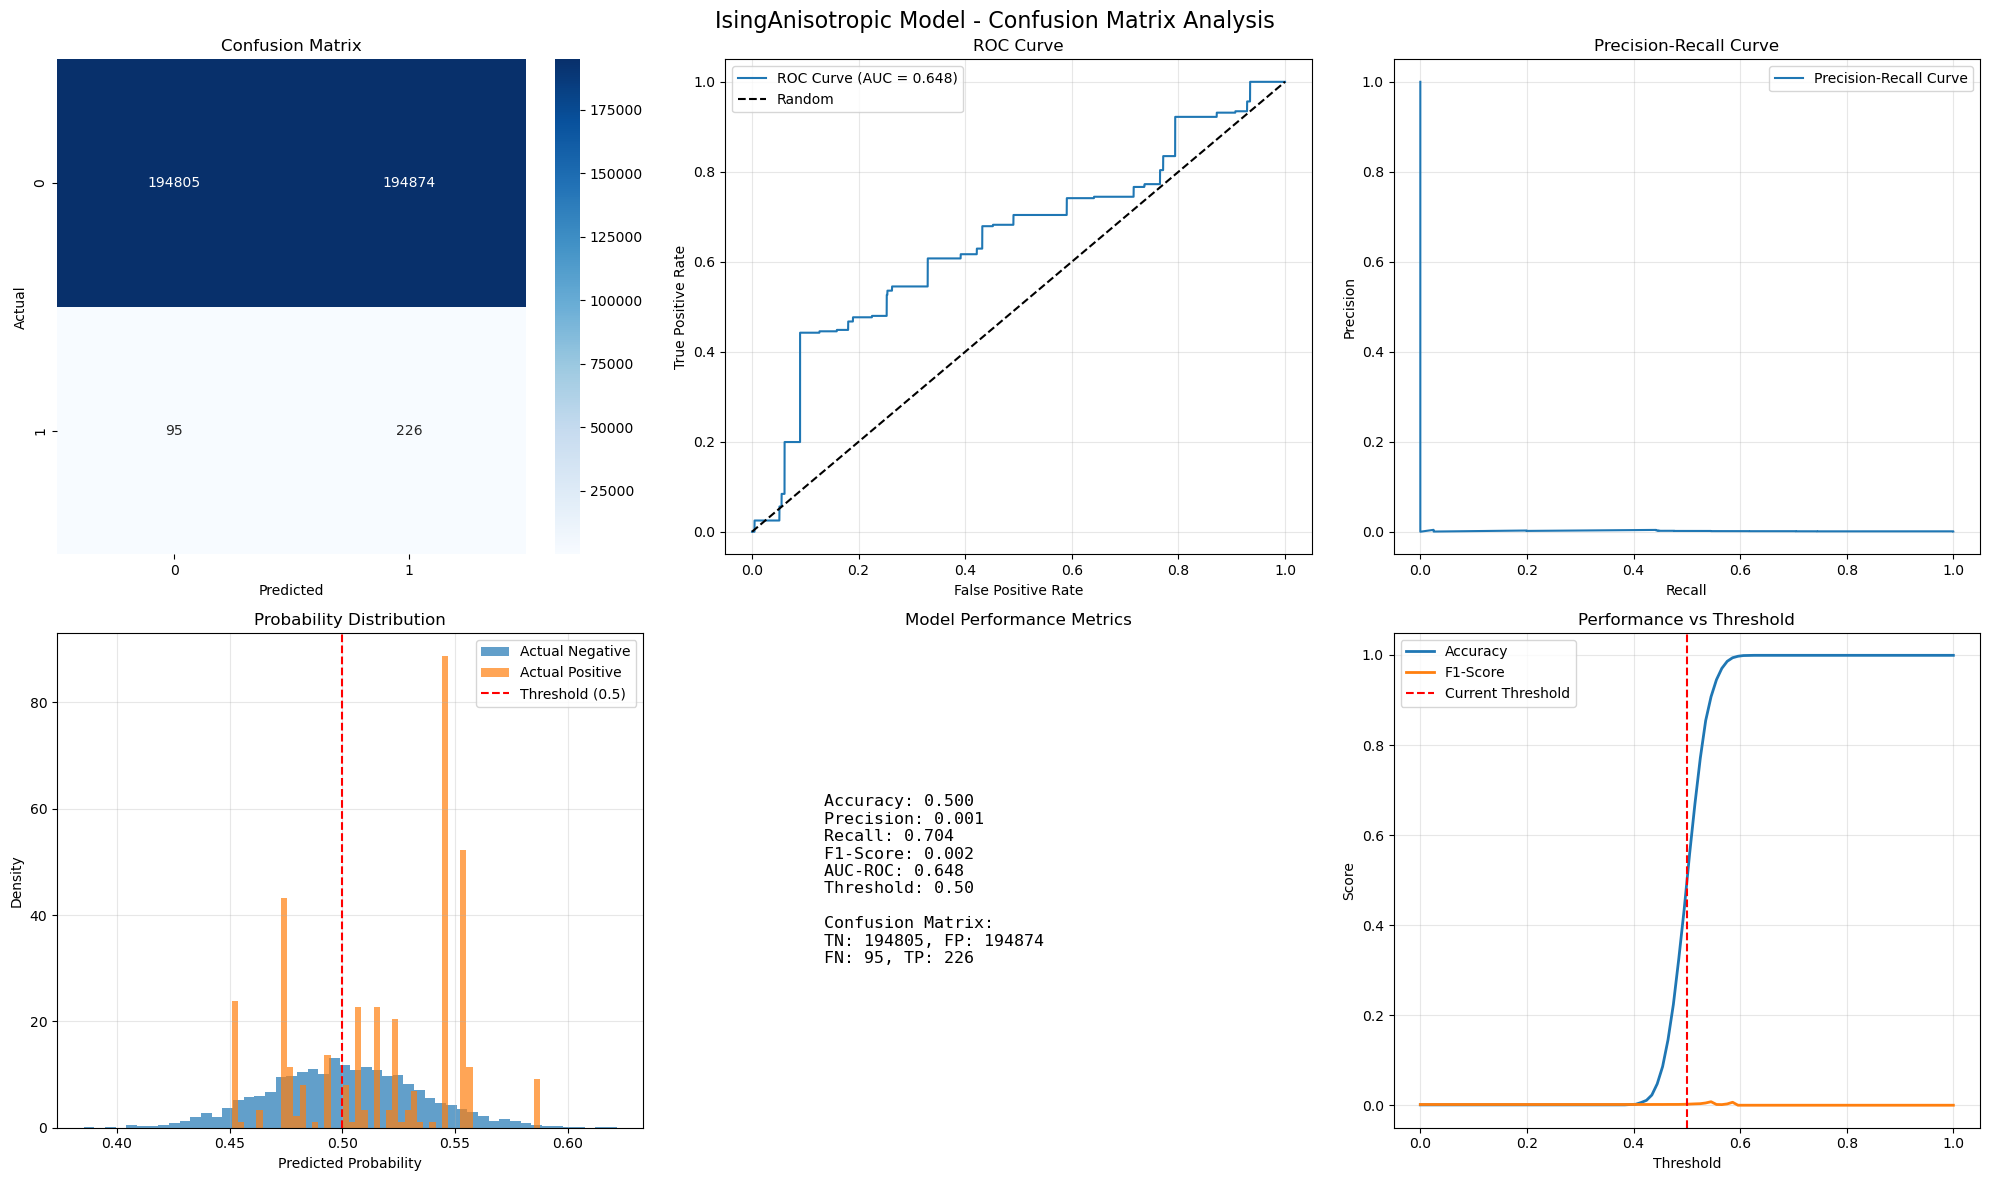


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       1.00      0.50      0.67    389679
    Positive       0.00      0.70      0.00       321

    accuracy                           0.50    390000
   macro avg       0.50      0.60      0.33    390000
weighted avg       1.00      0.50      0.67    390000


THRESHOLD OPTIMIZATION
Debug info:
  probs_mean shape: (100, 39)
  actual_data shape: (100, 39)
  n_patients: 100, n: 100, C: 39
  Padded actual_data with 3861 zeros
  actual_data_grid shape after reshape: (100, 100, 39)
  Final shapes: y_true=(390000,), y_pred_proba=(390000,)
Threshold 0.3: F1=0.002, Accuracy=0.001, Precision=0.001, Recall=1.000
Debug info:
  probs_mean shape: (100, 39)
  actual_data shape: (100, 39)
  n_patients: 100, n: 100, C: 39
  Padded actual_data with 3861 zeros
  actual_data_grid shape after reshape: (100, 100, 39)
  Final shapes: y_true=(390000,), y_pred_proba=(390000,)
Threshold 0.4: F1=0.002, Accuracy=0.

In [12]:
# Confusion Matrix Analysis - Fixed Version
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

def compute_confusion_matrix(probs_samples, actual_data, threshold=0.5):
    """
    Compute confusion matrix comparing predicted probabilities with actual data.
    
    Parameters:
    -----------
    probs_samples : np.ndarray
        Posterior predictive samples of shape (n_samples, n, C)
    actual_data : np.ndarray
        Actual observed data of shape (n_patients, n_conditions)
    threshold : float
        Probability threshold for binary classification
        
    Returns:
    --------
    dict : Dictionary containing confusion matrix and metrics
    """
    # Get mean probabilities across posterior samples
    probs_mean = np.mean(probs_samples, axis=0)  # Shape: (n, C)
    
    # Reshape actual data to match the grid structure
    n, C = probs_mean.shape
    n_patients = actual_data.shape[0]
    
    print(f"Debug info:")
    print(f"  probs_mean shape: {probs_mean.shape}")
    print(f"  actual_data shape: {actual_data.shape}")
    print(f"  n_patients: {n_patients}, n: {n}, C: {C}")
    
    # Pad or truncate actual data to match grid size
    grid_size = n * C
    if actual_data.shape[1] > grid_size:
        actual_data_grid = actual_data[:, :grid_size]
        print(f"  Truncated actual_data to {grid_size} conditions")
    else:
        # Pad with zeros if needed
        padding_size = grid_size - actual_data.shape[1]
        padding = np.zeros((actual_data.shape[0], padding_size))
        actual_data_grid = np.concatenate([actual_data, padding], axis=1)
        print(f"  Padded actual_data with {padding_size} zeros")
    
    # Reshape to match the grid structure
    actual_data_grid = actual_data_grid.reshape(n_patients, n, C)
    print(f"  actual_data_grid shape after reshape: {actual_data_grid.shape}")
    
    # Convert actual data from [-1, 1] to [0, 1] if needed
    if np.min(actual_data_grid) < 0:
        actual_data_grid = (actual_data_grid + 1) / 2
        print(f"  Converted actual_data from [-1,1] to [0,1]")
    
    # For each patient, compute the confusion matrix
    all_y_true = []
    all_y_pred_proba = []
    
    for patient in range(min(n_patients, 100)):  # Use first 100 patients
        # Get the patient's actual data
        patient_actual = actual_data_grid[patient, :, :]  # Shape: (n, C)
        
        # Flatten for comparison
        y_true_patient = patient_actual.flatten()  # Shape: (n*C,)
        y_pred_proba_patient = probs_mean.flatten()  # Shape: (n*C,)
        
        all_y_true.extend(y_true_patient)
        all_y_pred_proba.extend(y_pred_proba_patient)
    
    # Convert to numpy arrays
    y_true = np.array(all_y_true)
    y_pred_proba = np.array(all_y_pred_proba)
    y_pred = (y_pred_proba > threshold).astype(int)
    
    print(f"  Final shapes: y_true={y_true.shape}, y_pred_proba={y_pred_proba.shape}")
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Compute additional metrics
    if cm.size == 4:  # 2x2 matrix
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle case where we only have one class
        if cm.size == 1:
            tn, fp, fn, tp = cm[0,0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, 0
    
    # Calculate metrics
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Compute AUC-ROC
    try:
        auc_roc = roc_auc_score(y_true, y_pred_proba)
    except:
        auc_roc = np.nan
    
    return {
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc_roc': auc_roc,
        'threshold': threshold
    }

def plot_confusion_matrix_analysis(results, title="Confusion Matrix Analysis"):
    """
    Plot comprehensive confusion matrix analysis.
    """
    cm = results['confusion_matrix']
    y_true = results['y_true']
    y_pred = results['y_pred']
    y_pred_proba = results['y_pred_proba']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. ROC Curve
    try:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        axes[0,1].plot(fpr, tpr, label=f'ROC Curve (AUC = {results["auc_roc"]:.3f})')
        axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random')
        axes[0,1].set_xlabel('False Positive Rate')
        axes[0,1].set_ylabel('True Positive Rate')
        axes[0,1].set_title('ROC Curve')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    except:
        axes[0,1].text(0.5, 0.5, 'ROC Curve\nNot Available', ha='center', va='center')
        axes[0,1].set_title('ROC Curve')
    
    # 3. Precision-Recall Curve
    try:
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        axes[0,2].plot(recall, precision, label='Precision-Recall Curve')
        axes[0,2].set_xlabel('Recall')
        axes[0,2].set_ylabel('Precision')
        axes[0,2].set_title('Precision-Recall Curve')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    except:
        axes[0,2].text(0.5, 0.5, 'Precision-Recall\nNot Available', ha='center', va='center')
        axes[0,2].set_title('Precision-Recall Curve')
    
    # 4. Probability Distribution
    if len(np.unique(y_true)) > 1:
        axes[1,0].hist(y_pred_proba[y_true == 0], bins=50, alpha=0.7, label='Actual Negative', density=True)
        axes[1,0].hist(y_pred_proba[y_true == 1], bins=50, alpha=0.7, label='Actual Positive', density=True)
    else:
        axes[1,0].hist(y_pred_proba, bins=50, alpha=0.7, label='All Predictions', density=True)
    axes[1,0].axvline(results['threshold'], color='red', linestyle='--', label=f'Threshold ({results["threshold"]})')
    axes[1,0].set_xlabel('Predicted Probability')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('Probability Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Metrics Summary
    metrics_text = f"""
    Accuracy: {results['accuracy']:.3f}
    Precision: {results['precision']:.3f}
    Recall: {results['recall']:.3f}
    F1-Score: {results['f1_score']:.3f}
    AUC-ROC: {results['auc_roc']:.3f}
    Threshold: {results['threshold']:.2f}
    
    Confusion Matrix:
    TN: {cm[0,0]}, FP: {cm[0,1]}
    FN: {cm[1,0]}, TP: {cm[1,1]}
    """
    axes[1,1].text(0.1, 0.5, metrics_text, transform=axes[1,1].transAxes, 
                   fontsize=12, verticalalignment='center', fontfamily='monospace')
    axes[1,1].set_title('Model Performance Metrics')
    axes[1,1].axis('off')
    
    # 6. Threshold Analysis
    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    f1_scores = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba > thresh).astype(int)
        cm_thresh = confusion_matrix(y_true, y_pred_thresh)
        if cm_thresh.size == 4:
            tn, fp, fn, tp = cm_thresh.ravel()
            acc = (tp + tn) / (tp + tn + fp + fn)
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        else:
            acc = f1 = 0
        accuracies.append(acc)
        f1_scores.append(f1)
    
    axes[1,2].plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    axes[1,2].plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
    axes[1,2].axvline(results['threshold'], color='red', linestyle='--', label=f'Current Threshold')
    axes[1,2].set_xlabel('Threshold')
    axes[1,2].set_ylabel('Score')
    axes[1,2].set_title('Performance vs Threshold')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification report
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
    
    return results

# Compute confusion matrix
print("Computing confusion matrix...")
confusion_results = compute_confusion_matrix(probs_samples, A_data, threshold=0.5)

# Plot comprehensive analysis
print("Plotting confusion matrix analysis...")
plot_confusion_matrix_analysis(confusion_results, "IsingAnisotropic Model - Confusion Matrix Analysis")

# Additional analysis: Try different thresholds
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds_to_test:
    results = compute_confusion_matrix(probs_samples, A_data, threshold=threshold)
    print(f"Threshold {threshold:.1f}: F1={results['f1_score']:.3f}, "
          f"Accuracy={results['accuracy']:.3f}, "
          f"Precision={results['precision']:.3f}, "
          f"Recall={results['recall']:.3f}")
    
    if results['f1_score'] > best_f1:
        best_f1 = results['f1_score']
        best_threshold = threshold

print(f"\nBest threshold: {best_threshold:.1f} (F1 = {best_f1:.3f})")

# Plot with best threshold
if best_threshold != 0.5:
    print(f"\nPlotting analysis with optimal threshold ({best_threshold:.1f})...")
    best_results = compute_confusion_matrix(probs_samples, A_data, threshold=best_threshold)
    plot_confusion_matrix_analysis(best_results, f"IsingAnisotropic Model - Optimal Threshold ({best_threshold:.1f})")

print("Confusion matrix analysis complete!")

In [25]:
import numpy as np
import jax.numpy as jnp

# 1. Load 200 patients, discard the first 100
A, X_cov, condition_list = load_data(batch_size=200)
if A.ndim == 3:
    A_data = A[:, :, 0]
else:
    A_data = A
A_100_200 = np.array(A_data[100:200])  # ensure NumPy array for masking

# 2. Randomly mask some 1s
rng = np.random.default_rng(42)
mask = (A_100_200 == 1)
mask_indices = np.argwhere(mask)
n_to_mask = int(0.2 * len(mask_indices))  # mask 20% of the 1s
chosen = rng.choice(len(mask_indices), size=n_to_mask, replace=False)
masked_indices = mask_indices[chosen]
A_masked = A_100_200.copy()
for i, j in masked_indices:
    A_masked[i, j] = 0  # mask the 1

# Keep track of which positions were masked
masked_positions = set((i, j) for i, j in masked_indices)

# 3. Predict with the model
n_conditions = A_masked.shape[1]
n = int(np.ceil(np.sqrt(n_conditions)))
C = int(np.ceil(n_conditions / n))

# Use your get_gmrf_posterior_predictives function (no n_patients arg!)
probs_samples = get_gmrf_posterior_predictives(mcmc_samples, n, C, n_samples=100)
probs_mean = np.mean(probs_samples, axis=0)  # shape: (n, C)

# 4. For each masked 1, check if the model predicts it as 1
threshold = 0.5
recovered = 0
for i, j in masked_positions:
    grid_i = i // C
    grid_j = j % C
    if grid_i < probs_mean.shape[0] and grid_j < probs_mean.shape[1]:
        if probs_mean[grid_i, grid_j] > threshold:
            recovered += 1

recovery_rate = recovered / len(masked_positions) if masked_positions else np.nan
print(f"Recovery rate for masked 1s: {recovery_rate:.3f}")

Recovery rate for masked 1s: 0.304


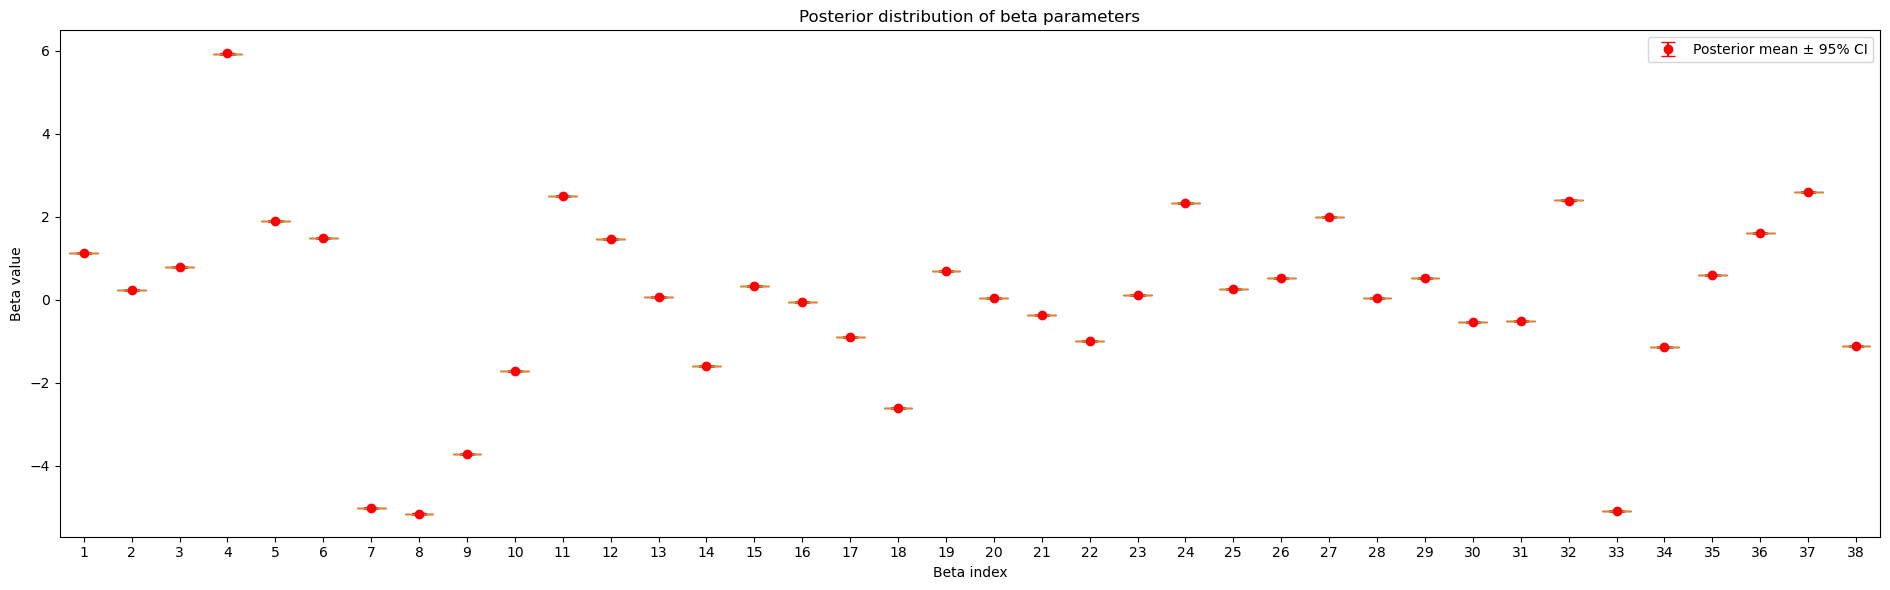

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Assume mcmc_samples is already loaded and contains 'beta' samples
beta_samples = np.array(mcmc_samples['beta'])  # shape: (num_samples, C-1)
num_betas = beta_samples.shape[1]

# Compute posterior mean and 95% credible interval for each beta
beta_means = np.mean(beta_samples, axis=0)
beta_lower = np.percentile(beta_samples, 2.5, axis=0)
beta_upper = np.percentile(beta_samples, 97.5, axis=0)

# Compute error bars (always positive)
yerr_lower = np.abs(beta_means - beta_lower)
yerr_upper = np.abs(beta_upper - beta_means)
yerr = np.vstack([yerr_lower, yerr_upper])

plt.figure(figsize=(max(8, num_betas // 2), 6))
plt.boxplot(
    beta_samples,
    positions=np.arange(1, num_betas+1),
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    vert=True  # <-- this ensures vertical boxplots (default)
)

# Overlay vertical error bars for the mean and 95% CI
plt.errorbar(
    np.arange(1, num_betas+1),  # x positions
    beta_means,                 # y values (means)
    yerr=yerr,                  # vertical error bars
    fmt='o', color='red', label='Posterior mean ± 95% CI', capsize=5
)

plt.xlabel('Beta index')
plt.ylabel('Beta value')
plt.title('Posterior distribution of beta parameters')
plt.xticks(np.arange(1, num_betas+1))
plt.legend()
plt.tight_layout()
plt.show()